## Sentiment Analysis
### Using Sentiment140 Tweet Corpus & SemEval Corpus Combined



In [2]:
# Load Packages

# Standard python helper libraries.
import collections
import itertools
import json
import os
import re
import sys
import time

# Numerical manipulation libraries.
import numpy as np
import pandas as pd
# from scipy import stats
# import scipy.optimize

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.

# Helper libraries (from w266 Materials).
# import segment
#from shared_lib import utils
# from shared_lib import vocabulary

# Machine Learning Packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Word2Vec Model
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import load_model

# Data Viz
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Python Reddit API Wrapper
import praw

### Load in Corpora & Clean

#### SemEval Corpus
Explanation of corpus.

Must download Tweet Data on your own, using the tutorial and code found here https://github.com/seirasto/twitter_download

In [3]:
# Load data as a pandas dataframe
cols = ['TweetID', 'Sentiment', 'SentimentText']
tweets = pd.read_table("Data/twitter_download-master/ALL_SEMEVAL_TRAIN_DATA.txt", header=None,
                       names=cols, encoding='ISO-8859-1', error_bad_lines=False)

# Drop extra columns
tweets.drop(['TweetID'], axis=1, inplace=True)

# # Remove Null Tweets
# tweets = tweets[tweets.Sentiment.isnull() == False]

# Map Integers to each of the categorical data (match with Sentiment 140 encoding)
tweets['Sentiment'] = tweets['Sentiment'].map({'negative':0, 'neutral':2, 'positive':4})

#### Sentiment 140 Corpus
Explanation of corpus.

In [4]:
# Load data as a pandas dataframe
cols2 = ['Sentiment', 'ItemID', 'DateTime', 'Query', 'SentimentSource', 'SentimentText']
tweets2 = pd.read_csv('Data/milliontweetCorpus/training.1600000.processed.noemoticon.csv', 
                     header=None, names=cols2, encoding='ISO-8859-1', error_bad_lines=False) #, nrows=num_tweets)

# Drop extra columns
tweets2.drop(['ItemID', 'DateTime', 'Query', 'SentimentSource'], axis=1, inplace=True)

# # Remove Null Tweets
# tweets2 = tweets2[tweets2.Sentiment.isnull() == False]

# Map Integers to each of the categorical data (0: Negative, 4: Positive)
tweets2['Sentiment'] = tweets2['Sentiment'].map(int)


Combine corpora

In [5]:
# Combine Dataframes
tweets = pd.concat([tweets,tweets2], axis=0)
#tweets = tweets2

# Remove Null Tweets, show shape, and print first 5 tweets
tweets = tweets[tweets['SentimentText'].isnull() == False]
tweets = tweets[tweets['SentimentText'] != 'Not Available']
tweets.reset_index(inplace=True)
tweets.drop('index', axis=1, inplace=True)
print('Concatenated DataFrame Shape:', tweets.shape)


Concatenated DataFrame Shape: (1616667, 2)


#### Explore a few of the Tweets

In [6]:
# Print a bunch of Random Tweets
i = 0
while i < 20:
    current = np.random.randint(0,tweets.shape[0]-1)
    sent = tweets.Sentiment[current]
    text = tweets.SentimentText[current]
    if sent == 0:
        i += 1
        print('Negative Tweet:', text)
    if sent == 4:
        i += 1
        print('Positive Tweet:', text)
    else:
        continue

Negative Tweet: @RogersKeith This has been a big problem. Many went on your advice this morning, only 2 waste time &amp; leave frustrated and angry.  Unha ...
Positive Tweet: tweet tweet! ... now what?   haha!
Positive Tweet: Prom was great 
Negative Tweet: What is happening with my Internet connection? Suddenly it became super slow 
Negative Tweet: @HansenBanana no one was on facebook so now I'm reading webcomics and watching other people live interesting lives via twitter. 
Positive Tweet: @cericsmith Thank you for the tweetlove! 
Positive Tweet: @ryanodonnell thanks for the rec on Drop7. that game is awesome!!! been waiting for something that can pull me away from my consoles.  
Negative Tweet: sadly i have realized that i cannot deactivate my fb because i desparately need someone to sublease from me. 
Negative Tweet: Everything tastes weird so i really dont want to eat or drink anything 
Positive Tweet: another gorgeous day ... planted my tubs in the garden yesterday ... am loving 

General thoughts of the corpora above:
1. Emoticons were removed from the Sentiment140 database but were NOT removed from the SemEval database. This could cause the model to pick up on that sequence of characters (ie. :(, =)) as defining features. Should remove.
2. Definitely some tweets I would say are miscategorized. For example: 'I love my sister a.k.a brianna!!! Missing her..we might be away by distance,never in heart..' is labeled Negative due to the presence of a :( in the original tweet. The accuracy of any model trying to predict Positive/Negative Sentiment on this corpus will consistently struggle to approach perfection due to these types of labels.
3. The general sentence structure here is grammatically awful and may not translate well to Reddit where individuals tend to hold more of a long-form conversation. 

### Cleaning

#### Tokenizing each Tweet

In [7]:
# Use NLTK's Tweet Tokenizer
t = TweetTokenizer()

def create_tokens(tweet):
    
    # Adjust all words in sentence to Lowercase
    tweet = str(tweet.lower())
    
    #Tokenize the sentence
    tokens = t.tokenize(tweet)
    
    # Filter out some unnecessary links, mentions, retweets, handles, and emoticons
    tokens = list(filter(lambda x: not x.startswith('@'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('#'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('RT'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('http'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':-)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(': )'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':D'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('=)'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':('), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(':-('), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith(': ('), tokens)) ##
    return tokens

tweets['SentimentTextTokenized'] = tweets['SentimentText'].apply(create_tokens)
tweets.head()


X = tweets.SentimentTextTokenized
Y = tweets.Sentiment

#### Visual Exploration (we can do better, if time)

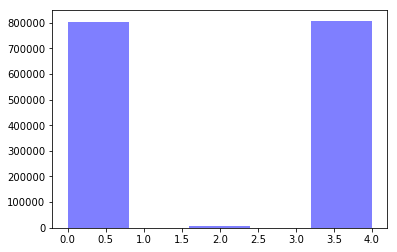

In [8]:
num_bins = 5
n, bins, patches = plt.hist(tweets.Sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Because the two corpora are combined, we see 3 categories in this Training Dataset. Negative = 0, Neutral = 2, Positive = 4

### Preprocessing & Feature Engineering

In [9]:
# Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=100)

print(X_train[:5])
print(y_train[:5])

1418399    [just, did, a, test, drive, with, the, bmw, 11...
1590568    [good, luck, lauren, ., i, know, you, are, goi...
1426864    [shipley's, donuts, sounds, amazing, right, no...
711160     [i, dont, like, it, at, all, ., its, confusing...
1576708                          [i, got, it, ..., hehehehe]
Name: SentimentTextTokenized, dtype: object
1418399    4
1590568    4
1426864    4
711160     0
1576708    4
Name: Sentiment, dtype: int64


### Convert Words into Vector Representation

Leveraging GenSim's Word2Vec model to convert our vocabulary into a vocabulary of word vectors.

In [10]:
# Specify the Word Vector Dimensionality
vector_dim = 100

# Threshold for words to be included (helps remove rare words)
thresh = 5

W2Vmodel = Word2Vec(size=vector_dim, min_count=thresh)
W2Vmodel.build_vocab(x for x in X_train)
W2Vmodel.train((x for x in X_train), total_examples=W2Vmodel.corpus_count, epochs=2)

13999745

Explore a few similar words using Word2Vec's most_similar function

In [11]:
def print_similar(word):
    print('##### %s #####' %word)
    for each in W2Vmodel.most_similar(str(word)):
        print('%i%% %s' %(each[1]*100, each[0]))
    print('')

print_similar('potato')
print_similar('hilarious')
print_similar('tuesday')
print_similar('trump')    

##### potato #####
93% homemade
92% grilled
91% blueberry
91% peanut
91% butter
91% choc
91% rice
91% lemon
91% garlic
91% sausage

##### hilarious #####
81% funny
78% awsome
77% amazing
76% awesome
76% dope
76% adorable
74% scary
74% brilliant
72% incredible
70% creepy

##### tuesday #####
95% wednesday
92% thursday
89% monday
83% friday
82% saturday
80% wed
78% thurs
78% tues
77% sunday
73% fri

##### trump #####
84% donald
84% president
83% jeb
83% bush
82% hillary
81% obama
80% barack
79% sanders
79% murray
79% biden



### Convert Tweets into Vector Representation

First attempt was to simply average all of the word vectors present in a single tweet.

Second attempt utilized TFIDF rankings for each word to take into account the rarity/importance of that word within the overall corpus. 



In [12]:
def buildTweetVector(tokens, vector_dim):
    
    # Initialize a blank vector of shape (1,vector_dim)
    tweet_vec = np.zeros(vector_dim).reshape((1, vector_dim))
    
    # Initialize # of words in tweet count
    count = 0.
    
    for word in tokens:
        try:
            # Take each word vector in the tweet and add each dimension to the overall tweet vector
            tweet_vec += W2Vmodel[word].reshape((1, vector_dim))
            
            # Increment Count
            count += 1.
            
        except:
            continue
    
    # Average each vector parameter by the # of words in the tweet (pass if no words exist in tweet)
    if count != 0:
        tweet_vec /= count
    
    # Return Tweet Vector
    return tweet_vec

#### Build TFIDF Dictionary

In [13]:
# Fit a TFIDF vectorizer model to the training set
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
vectorizer.fit_transform([x for x in X_train])

# Extract IDF values from model and place into a dictionary
tfidf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [17]:
def buildTweetVectorTFIDF(tokens, vector_dim):
    
    # Initialize a blank vector of shape (1,vector_dim)
    tweet_vec = np.zeros(vector_dim).reshape((1, vector_dim))
    
    # Initialize # of words in tweet count
    count = 0.
    
    for word in tokens:
        try:
            # Same as above, only now multiply the tfidf score for the current word by its vector 
            # (to add additional weight to more important words with respect to the corpus)
            tweet_vec += W2Vmodel[word].reshape((1, vector_dim)) * tfidf_dict[word]
            
            # Increment Count
            count += 1.
            
        except:
            continue
    
    # Average each vector parameter by the # of words in the tweet (pass if no words exist in tweet)
    if count != 0:
        tweet_vec /= count
    
    # Return Tweet Vector
    return tweet_vec

#### Turn Training and Test Sets into Tweet Vectors
Pass each tweet in the Training/Test Sets into the buildTweetVector function and reassemble training/test set structure

In [18]:
X_train_tweet_vecs = np.concatenate([buildTweetVectorTFIDF(vec, vector_dim) for vec in map(lambda x: x, X_train)])
X_test_tweet_vecs = np.concatenate([buildTweetVectorTFIDF(vec, vector_dim) for vec in map(lambda x: x, X_test)])

#### Scale each Vector

In [19]:
scaler = StandardScaler()
scaler.fit(X_train_tweet_vecs)
X_train_tweet_vecs = scaler.transform(X_train_tweet_vecs)
X_test_tweet_vecs = scaler.transform(X_test_tweet_vecs)

#### Encode the Y Labels as Categorical Variable and then One-hot Encode (for multi-class classification)

In [20]:
print("Original Y:", y_train[:10])
encoder = LabelEncoder()
encoder.fit(Y)
y_train = encoder.transform(y_train)
y_test= encoder.transform(y_test)
print("Encoded Y:", y_train[:10])

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print("One Hot Y:", y_train[:10])

Original Y: 1418399    4
1590568    4
1426864    4
711160     0
1576708    4
54615      0
6138       2
974273     4
84989      0
1397183    4
Name: Sentiment, dtype: int64
Encoded Y: [2 2 2 0 2 0 1 2 0 2]
One Hot Y: [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]


## Fit a 'Simple' Neural Network Model using the Tweet Vectors as Features

Using Keras & Tensorflow backend.

In [21]:
# Keras Model w/ Two Affine Layers
model = Sequential()
model.add(Dense(32, activation='softmax', input_dim=vector_dim))
model.add(Dense(3, activation='softmax')) # softmax for multi-class
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', # categorical_crossentropy if multi-class
              metrics=['accuracy'])

model.fit(X_train_tweet_vecs, y_train, epochs=1, batch_size=32, verbose=2)

Epoch 1/1
 - 52s - loss: 0.5039 - acc: 0.7654


#### Evaluate Model on Test Set

In [22]:
accuracy = model.evaluate(X_test_tweet_vecs, y_test, batch_size=32, verbose=2)
print("Accuracy: %.2f%%" % (accuracy[1]*100))

Accuracy: 77.25%


#### Save Keras Model

In [23]:
# Save Keras Model to File (not working on Matt's computer)
# model.save('sentiment_model.h5')

### Apply Fitted Model to Reddit

In [24]:
# Function to Predict Positive/Neutral/Negative
# def prediction(text):
#     sentiment = ["Negative",'Neutral', "Positive"]
#     text = text.split() # Tokenize
#     text = buildTweetVectorTFIDF(text, vector_dim)
#     text = scaler.transform(text)
#     prediction = model.predict(text, batch_size=32)
#     result = sentiment[prediction.argmax(axis=1)[0]]
#     return result

def prediction(text):
    sentiment = ["Negative",'Neutral', "Positive"]
    tokens = create_tokens(text)
    vectors = buildTweetVectorTFIDF(tokens, vector_dim)
    vectors = scaler.transform(vectors)
    predic = model.predict(vectors)
    result = sentiment[predic.argmax(axis=1)[0]]
    return result

# Load saved Keras Model from File (not working on Matt's computer)
# my_model = load_model('sentiment_model.h5')

#### Longer Reddit pulls from the hottest non-promoted sub-reddit using the praw package to interact with Reddit's API and pull all comments from a single page

##### Subreddit = Portland

In [39]:
subreddit = reddit.subreddit('Portland')
hot_post = subreddit.hot(limit = 3)
col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

df = pd.DataFrame(columns = col_list)


for submission in hot_post:
    if not submission.stickied:
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(submission.title,
                                                                          submission.ups,
                                                                          submission.downs,
                                                                          submission.visited))
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads
        #this will throttle for bigger pages...
        for i, comment in enumerate(submission.comments.list()):
            print (20*'-')
            print ('Parent ID:', comment.parent()) #context builder
            print ('Comment ID:', comment.id) #unique id
            print (comment.body)
            print("#"*10,'PREDICTED SENTIMENT:', prediction(comment.body),"#"*10)
            df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
            
df.to_csv('r_portland'.csv, encoding='utf-8', index=False)

Title: ESSAY: My lame-o perspective from listening to the PPB/Multnomah Co. police scanner for the last few weeks, ups: 241, downs: 0, Have we visited: False
--------------------
Parent ID: 7ipy1d
Comment ID: dr0lxpn
I go on ridealongs with the PPB pretty often. I highly reccomend doing one graveyard shift on a busy night (4th of july, veterans day, a super hot saturday on a full moon etc.) 

They are great men and women (mostly) who work super hard. Aside from a shocking amount of bullshit, there is a shocking amount of violent crime. Shootings, fights, carjackings. Things you don't hear about or associate with peaceful little Portland. You likely won't see one of these calls yourself but you'll hear them come in over the radio a lot.

They are also so understaffed and overworked. One time the officer I was with told me back-up was 10 minutes away and we were within city limits. Crazy. Another time dispatch put everyone in portland on "priority calls only" which meant that there were 

Parent ID: dr0t905
Comment ID: dr0thtx
Its not like its hard to get hired. Last time I checked, they wanted you to have an associates or better, pass drug, physical and psych tests and a criminal record check. Until more people start realizing its a decent career, the under-staffing is only going to get worse. Also, working cops on overtime tends to be cheaper than hiring new ones, so it comes down to that when budget cuts hit.
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0yfn7
Comment ID: dr0z5rh
I did too. They do. There are just very few cops assigned to the very large beat area that encompasses that area, so you are very unlikely to see cops there. 
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0tk5w
Comment ID: dr0u132
It's not even the record that is so much the problem. You can have a record and still be a cop, but you just have to be completely up front about it. Many times it's not even having a r

Parent ID: dr0d0op
Comment ID: dr0ihbt
I wrote a longer comment about this but my issue isn't that it's in my neighborhood, it's in a neighborhood who already gets screwed over when it comes to city resources. I have a camp near me and I'm find with it.  
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0d0op
Comment ID: dr0lkx6
Well, by doing something, I don't know if 'providing more amenities to invite more' was at the top of the collective list.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0d0op
Comment ID: dr0e0bq
Don't worry your neighborhood is high priced low density.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0lqtt
Comment ID: dr0oaol
I’m guardedly optimistic about this, but I have concerns. I recently purchased the old Pal Do Market property and my business partner and I are working to start a brewery/pub in that space, so I have mixed feelings. If it’s man

Yeah, it's Off the Griddle now, which was pretty good when I went in. I thought it represented a change of course for the area (vegetarian food instead of dive bar), but now with our homeless friends likely to descend in a cloud of needles and yard turds...
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0hcbn
Comment ID: dr0odks
If what I heard is accurate, it was a family member (daughter?) of one of the Gypsy Jokers who bought the Gemini and opened/ran the Double Treble. That place was fucked since Jump Street. 
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0hwcl
Comment ID: dr0lgcl
Yeah, I really enjoyed it during its heyday - the sliders were all nice and tasty, even the well liquor was mid shelf at least, all the beers were super local, and the decor was comfy. Then it went a bit sideways...
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0p8he
Comment ID: dr0pisg
I

AttributeError: 'str' object has no attribute 'csv'

Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4561, downs: 0, Have we visited: False


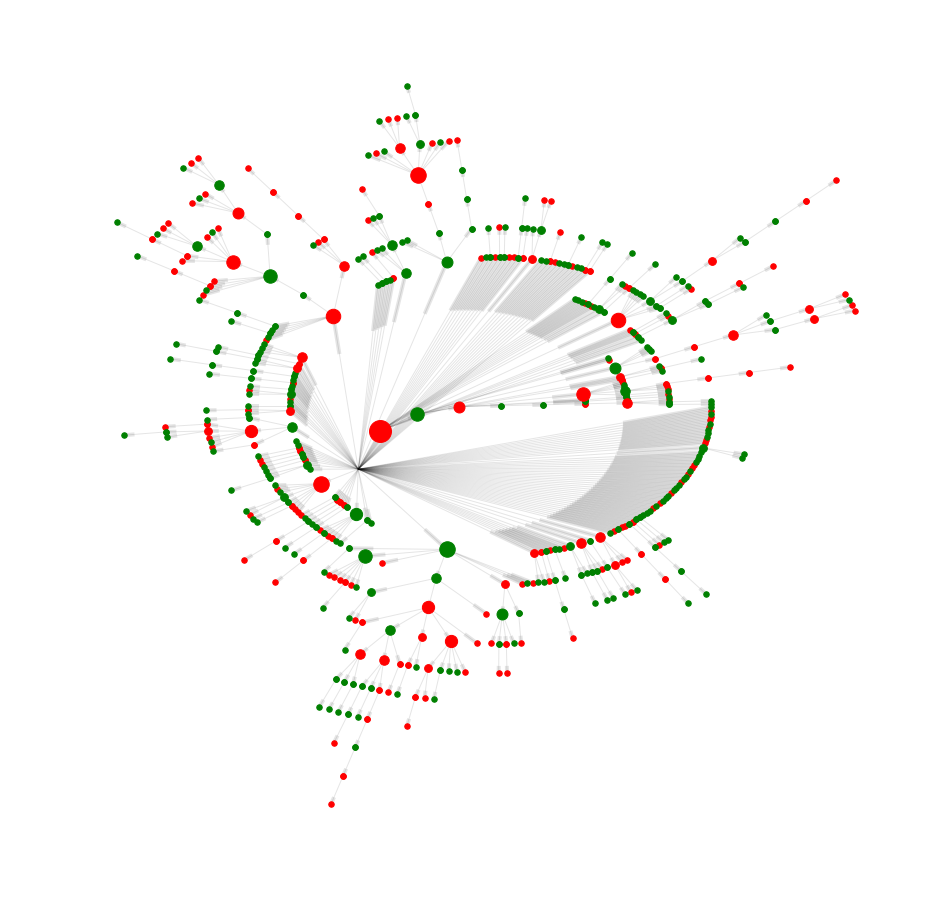

In [40]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.graphviz_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()

##### Subreddit = movies

In [41]:
subreddit = reddit.subreddit('movies')
hot_post = subreddit.hot(limit = 3)
col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

df = pd.DataFrame(columns = col_list)


for submission in hot_post:
    if not submission.stickied:
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(submission.title,
                                                                          submission.ups,
                                                                          submission.downs,
                                                                          submission.visited))
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads
        #this will throttle for bigger pages...
        for i, comment in enumerate(submission.comments.list()):
            print (20*'-')
            print ('Parent ID:', comment.parent()) #context builder
            print ('Comment ID:', comment.id) #unique id
            print (comment.body)
            print("#"*10,'PREDICTED SENTIMENT:', prediction(comment.body),"#"*10)
            df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
            
df.to_csv('r_movies.csv', encoding='utf-8', index=False)

Title: Lucasfilm to start production on Obi-Wan Kenobi Star Wars spinoff in January 2019, ups: 18541, downs: 0, Have we visited: False
--------------------
Parent ID: 7iqd77
Comment ID: dr0nsso
I hope they make it a low-stakes character piece for Obi-Wan similar to how Logan was for Wolverine. Also it is essential to have Ewan McGregor reprise his role.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0oamb
Help us, Ewan. You're our only hope. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0nbng
#BringBackEwan
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0v0ws
I wonder if they mean old Ben Kenobi?
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0m8t1
At this point I just assume there's production starting on a new Star Wars film every single day.
########## 

Comment ID: dr0pj5c
My money is on Rey being OW's grandkid and this movie will show Obi-Wan meeting Rey's grandma. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0w3pc
We've literally seen every phase of Obi Wan Kenobi's life other than hiding on Tattooine.  What is this movie going to be about, lol
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0wmk5
If Ewan isn’t in this there will be riots
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0sjnm
Make them stop, please make them stop. As a comedian so lovely stated "it's like they dug up the bones of my best friend and are making me play with it"
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: 7iqd77
Comment ID: dr0xh8t
If isn't Ewan then just cancel this shit right now.
########## PREDICTED SENTIMENT: Negative ##########
--------

Parent ID: dr0nsso
Comment ID: dr0xkra
I still say the new trilogy is going to reveal that PA + OWK = L & L, and this movie will follow in the wake of that.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0nsso
Comment ID: dr0w8xg
The story of how Obi-Wan became Ben.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0nsso
Comment ID: dr0whjq
I just hope whatever they do, they take their time.

Quality over quantity...
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0nsso
Comment ID: dr0whyf
They kinda have to, what with how he can't leave the planet and everything... My bet is on bringing in Maul, unless that was dealt with in Rebels (I'm about a season behind and planning a binge before TLJ, so pls don't spoil).
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0nsso
Comment ID: dr0wy1s
Maybe save some people on tatooine or something.
####

########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0no8t
Comment ID: dr0v4ou
Personally I'd like to see a story on the friendship between Dr Evazan and Ponda Baba.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0no8t
Comment ID: dr0wv6t
The article talks about rumors about spinoffs for Yoda, Boba Fett, Jabba the Hutt... Honestly, your idea would be so much better than any of those. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0no8t
Comment ID: dr0xbki
We need a spinoff about the guy on Bespin with the ice cream maker.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0no8t
Comment ID: dr0xx0d
We need a backstory for Salacious B. Crumb
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0r62i
Comment ID: dr0sx5l
I actually liked that scene.

Maul knew he wasn't going to win. he was broken and significant

########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0nxoc
Comment ID: dr0t6it
We don’t really know to what lengths Obi Wan went to protect Luke. Could be interesting. 
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0nxoc
Comment ID: dr0z8hf
> The only issue I seeing is making the stakes believable, the plot will have to be loosely rated to the original trilogy but at the same time tel l a new story that we don't know the ending too (protecting luke, fighting vader, etc...)

* Obi-Wan settles on Tatooine, flash backs to the war and Mustafar
* Watches over toddler Luke, careful friends with Owen and Beru, saves them from sand people going full bad ass Jedi
* Later on, gets contacted by an old friend (Maybe the diner alien) who found out about a Jedi padawan on the run from Vader and the Empire in the Outer Rim, nearby
* Obi-Wan has to help the padawan escape from Vader, go undercover and start over, all the while hi

########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0ozh8
Comment ID: dr0wwgr
One of my favorite scenes in the entire prequel trilogy. That and his fight vs jango in the rain.
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0ozh8
Comment ID: dr0x1gw
Damn he is perfect for the roll.

Damn I forgot how much pure CGI suck.
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0ozh8
Comment ID: dr0x7jz
General Grievious is my favorite nemesis.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0ozh8
Comment ID: dr0z9wm
Grievous was such a cool "end boss" character. He manages to challenge a Jedi while not being Sith. I honestly think he was one of the most creative ideas of the PT.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0ozh8
Comment ID: dr0xv2c
I know this would make a boring scene in the movie, but couldn

########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0x46t
Comment ID: dr0xsaj
Obi wan Yojimbo
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0x46t
Comment ID: dr0y57k
read the Kenobi novel this is exactly that and it's amazing.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0x46t
Comment ID: dr0zia2
I was not impressed by the idea of an Old Ben spin off. 

I would be somewhat impressed by a Ewan Mcgregor spin off. 

However, if it was an old ben Ewan Mcgregor Scifi western with non-world ending stakes, that would be honestly be in the running for best film in the SW universe 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0xewd
Comment ID: dr0xl8h
I think I was just subconsciously repeating the plot for the old cannon book named "Kenobi".  I don't think it applies anymore, though the story is universal. As commented above, it's Clint Eas

--------------------
Parent ID: dr0rzlt
Comment ID: dr0y9tj
Luke is riding his toddler speeder along the dune sea and some banthas come charging down into a coulee that he's chasing womp rats in.. Old Ben Kenobi to the rescue! And it just gets better from there until the final day leading into A New Hope when on that final day he's clearing sith assassins that have gotten wind of the whereabouts of the offspring of Anakin Skywalker. An epic duel with Darth Something Something ensues all while simultaneously battling an onslaught of lower mid-count sith knights and mercenaries leaving only two sith in the galaxy...


########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0t6it
Comment ID: dr0xone
Yeah, we do. It's in the comics / Rebels TV show.


########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0wjh3
Comment ID: dr0xlab
Reintroducing mutants into a world that tried to exterminate them could be world-altering, though. T

Comment ID: dr0nmbj
Might be complete BS but:

https://screenrant.com/han-solo-ron-howard-reshoots-budget/
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0nda8
Comment ID: dr0njeh
CIA transmission picked up on dentures
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0nda8
Comment ID: dr0pq0d
The Force is strong with him.  He felt a great disturbance in The Force.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0pwaa
Comment ID: dr0qv60
Exactly. There's nothing they can really do with the character development wise because the movie has to end with him being the same selfish asshole we meet in ANH. Maybe I'm wrong and they've got a brilliant story that manages that perfectly, but I highly doubt it.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0pwaa
Comment ID: dr0r1ov
I'm gonna agree with Red Letter Media's prediction that all of the

########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0xbyd
Comment ID: dr0ydmp
Yeah, he didn't lose any lightsaber battles did he?
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0xbyd
Comment ID: dr0z4mo
Obi-Wan was a fucking badass duelist.
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0uobh
Comment ID: dr0wq3q
You’re right. They used the scene from A New Hope when Luke and R2 get saved by Obi-Wan from the sand people and Kenobi tells R2 “come here my little friend, don’t be afraid.” 

They cut off the “afr” and the d at the end to make him say Rey. It was coincidence that his intonation made it sound like he was calling her. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0uobh
Comment ID: dr0vwpb
I believe you are correct. 
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0uobh
Comment ID: dr0x1ze


Parent ID: dr0xfjv
Comment ID: dr0yocu
You are a bold one!
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0xg83
Comment ID: dr0xpb4
Yipee!
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0xg83
Comment ID: dr0xzmm
But what about the droid attack on the Wookiees?
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0x8z2
Comment ID: dr0xd5d
It definitely wouldn't work *as well*. But people loved him for Alec too, not just Ewan. Padawan Obi Wan is definitely the least interesting idea they could do without being downright bad, but at worst it's not worse than the Han movie they're doing anyway.
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: dr0s0tz
Comment ID: dr0x24x
Arguably it applied to every "Jurassic" film released after the first, depending on your perspective.
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Pare

From a certain point of view...
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0xfig
Comment ID: dr0zhls
If they could do that, they would. It'd be cheaper than buying off congress to keep on extending copyrights. Wouldn't need to do that if all the original authors were still alive. 
########## PREDICTED SENTIMENT: Positive ##########
--------------------
Parent ID: dr0wpa3
Comment ID: dr0ygz0
I thought it was impressive how small a part he played in that movie, even though he ended up the big hero at the end. 
########## PREDICTED SENTIMENT: Positive ##########


Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4561, downs: 0, Have we visited: False


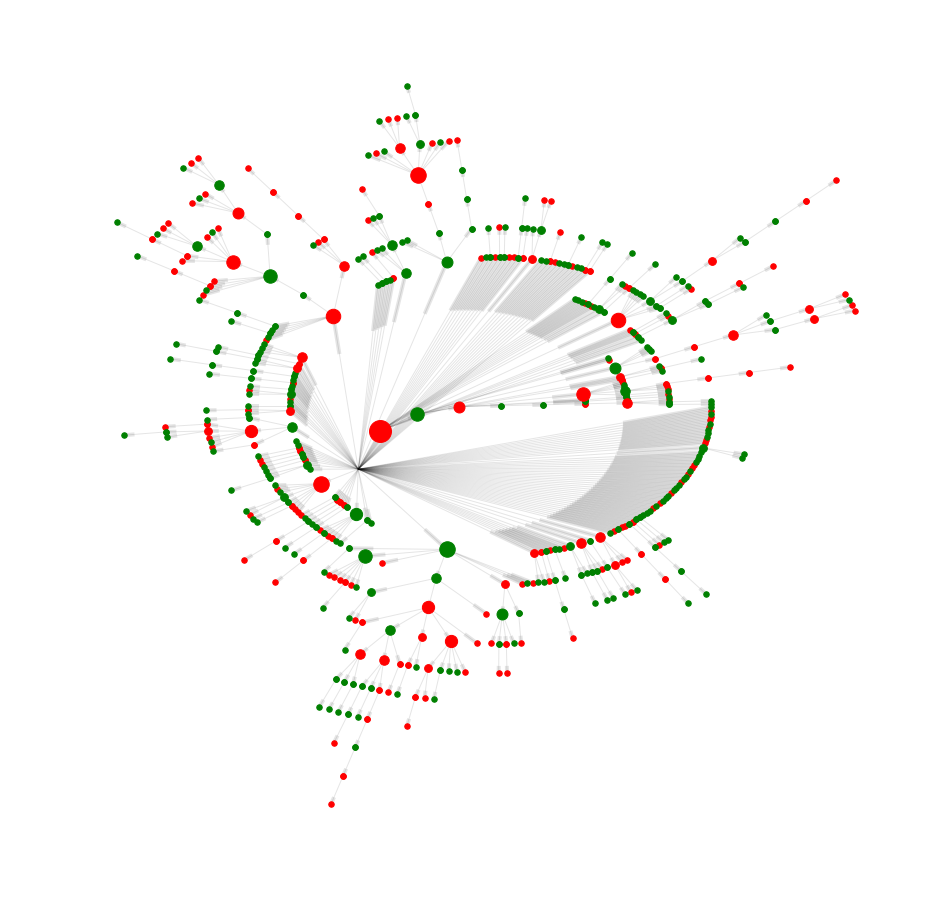

In [42]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.graphviz_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()

### Limitations of this corpora on the Reddit Feeds

Unfortunately, sentence structure on Reddit appears to be substantially different compared to tweet structure on Twitter both in grammar use and in length of post. Because the model was built using a corpus that is only 140 characters long (maximum). Considering the creation of a Tweet vector is just an averaging across all of the individual word vectors, theoretically this process should translate to a full Reddit sentence though due to the increased length of a Reddit sentence any 'rare' or 'important words' seen will be more likely to be averaged out in a longer post.

# -----DEVELOPMENT AREA-------

# Trying to Visualize a Network with Positive Nodes = Green, Neg=Red

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict

# Initialize a read-only instance
reddit = praw.Reddit(user_agent='first_scrape (by /u/dswald)',
                     client_id='TyAK1zSuAvQjmA', 
                     client_secret="uxHGsL0zNODbowN6umVnBWpqLAQ")

In [ ]:
# Select Url / Subreddit page to view
page = 'canada'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts
col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

df = pd.DataFrame(columns = col_list)

G_dict = {}

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads

        comments = submission.comments.list() #unstructured
        G = nx.DiGraph()
        positive_nodes = []
        negative_nodes = []
        # Build empty dict
        degrees = {}
        for i in range(1,30):
            degrees[i] = []
            
        for i, comment in enumerate(comments):
            df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
            try:
                sentiment = str(prediction(comment.body))
                if sentiment == "Negative":
                    negative_nodes.append(comment.id)
#                     degree.append(nx.degree(G))
                if sentiment == "Positive":
                    positive_nodes.append(comment.id)
                G.add_node(comment.id)
                G.add_edge(comment.parent(), comment.id)
            except:
                continue
            
        degree = nx.degree(G)
        for id,count in degree.items():
            for i in range(1,30):
                if count == i:
                    degrees[i].append(id)
        G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)
        
df.to_csv(page+'.csv', encoding='utf-8', index=False)

In [27]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    #pos = nx.random_layout(G[0])
    pos = nx.circular_layout(G[0])
    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()

Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4561, downs: 0, Have we visited: False


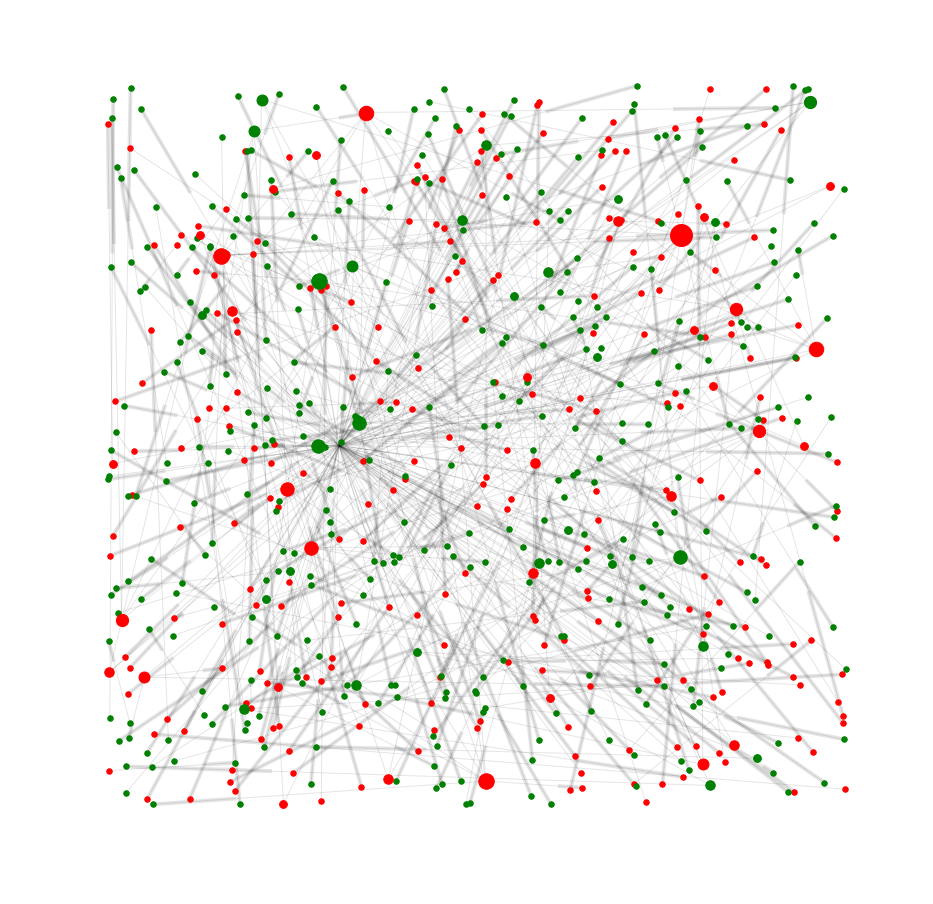

In [30]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.random_layout(G[0])
    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()

Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4561, downs: 0, Have we visited: False


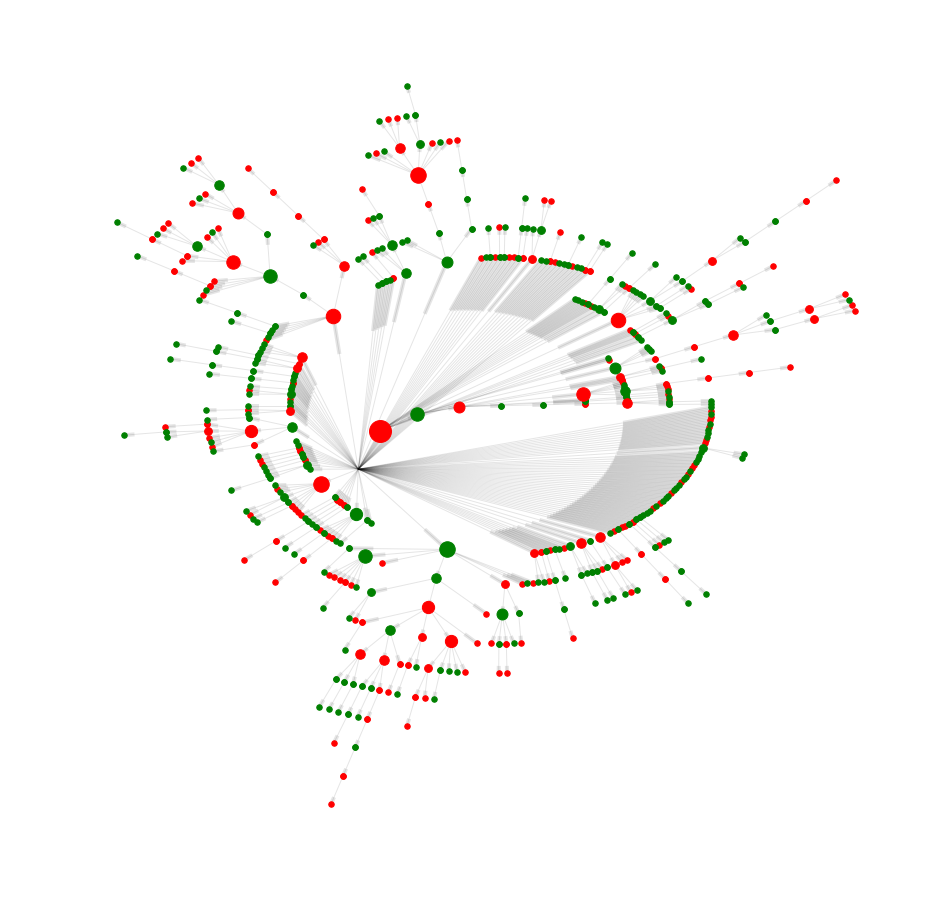

In [33]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.graphviz_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()

Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4561, downs: 0, Have we visited: False


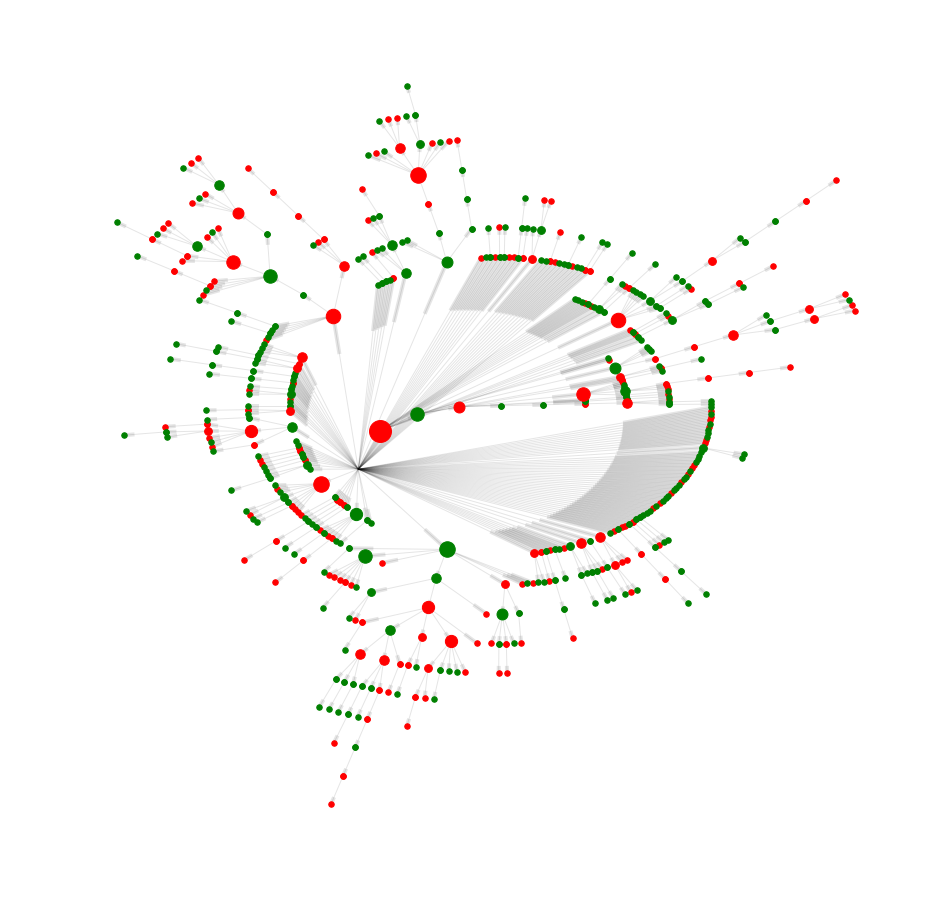

In [34]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.pydot_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()
    
    

Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4561, downs: 0, Have we visited: False


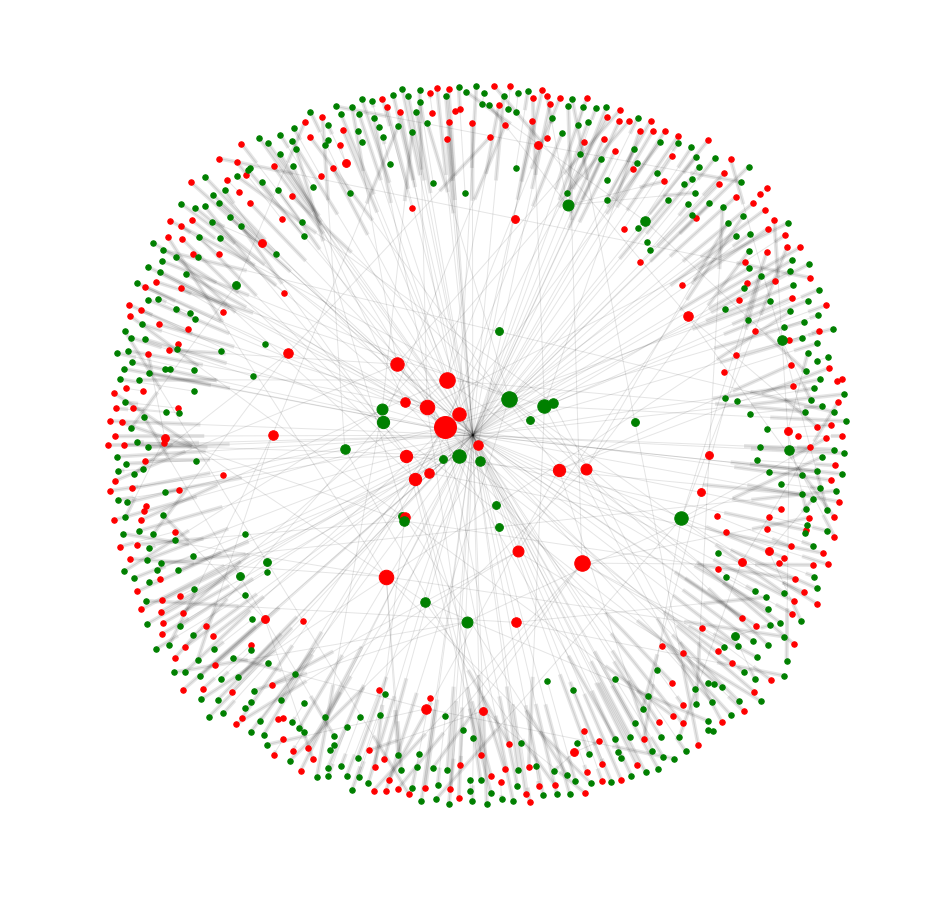

In [35]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.spring_layout(G[0])
    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()

Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4561, downs: 0, Have we visited: False


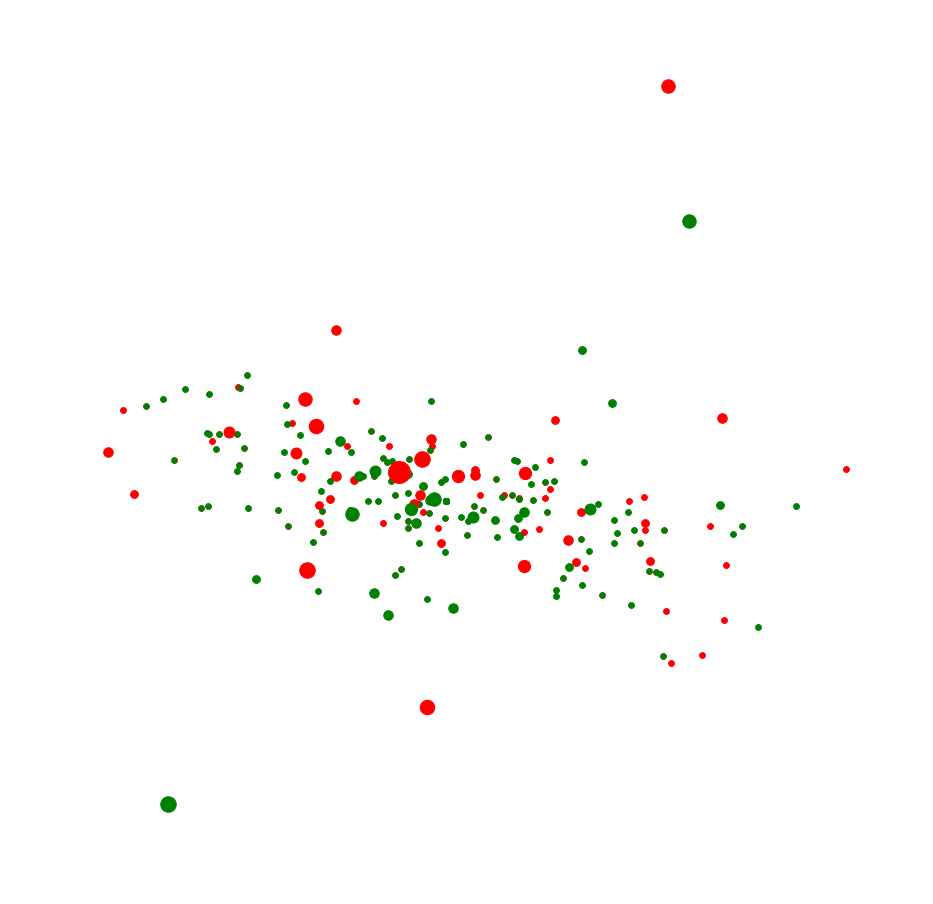

In [38]:
i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.spectral_layout(G[0])
    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()

### final code

Title: A Sankey Diagram I made of Canada's Population Breakdown, ups: 4587, downs: 0, Have we visited: False


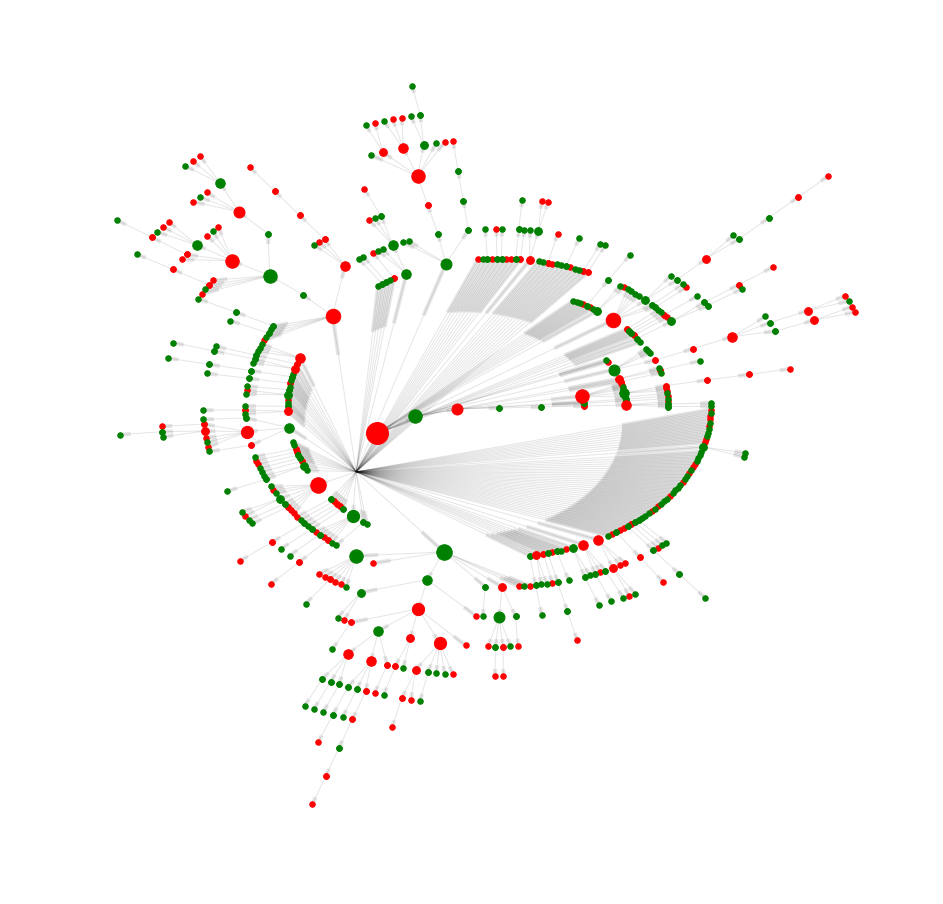

In [43]:
# Select Url / Subreddit page to view
page = 'canada'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts
col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

df = pd.DataFrame(columns = col_list)

G_dict = {}

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads

        comments = submission.comments.list() #unstructured
        G = nx.DiGraph()
        positive_nodes = []
        negative_nodes = []
        # Build empty dict
        degrees = {}
        for i in range(1,30):
            degrees[i] = []
            
        for i, comment in enumerate(comments):
            df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
            try:
                sentiment = str(prediction(comment.body))
                if sentiment == "Negative":
                    negative_nodes.append(comment.id)
#                     degree.append(nx.degree(G))
                if sentiment == "Positive":
                    positive_nodes.append(comment.id)
                G.add_node(comment.id)
                G.add_edge(comment.parent(), comment.id)
            except:
                continue
            
        degree = nx.degree(G)
        for id,count in degree.items():
            for i in range(1,30):
                if count == i:
                    degrees[i].append(id)
        G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)
        
df.to_csv(page+'.csv', encoding='utf-8', index=False)

i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.pydot_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()
    
    

Title: ESSAY: My lame-o perspective from listening to the PPB/Multnomah Co. police scanner for the last few weeks, ups: 242, downs: 0, Have we visited: False


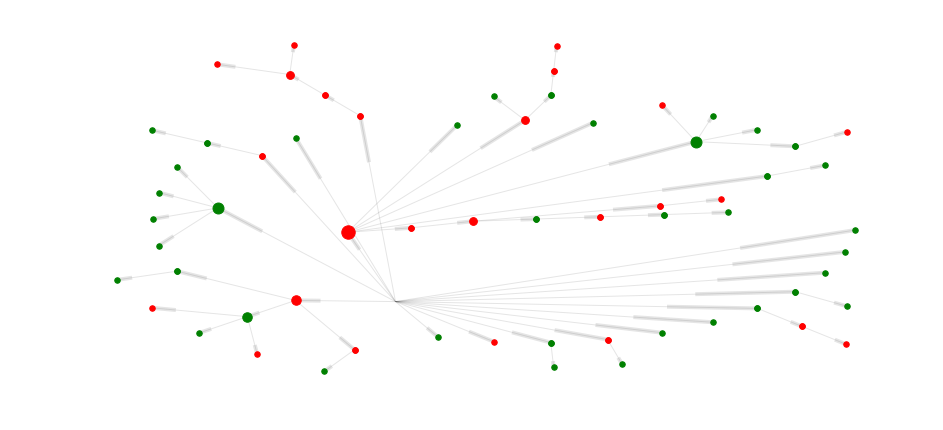

Title: City adding a homeless shelter on Foster Road and 61st. Discussion 12/18 7pm at SEIU (Foster and 64th), ups: 89, downs: 0, Have we visited: False


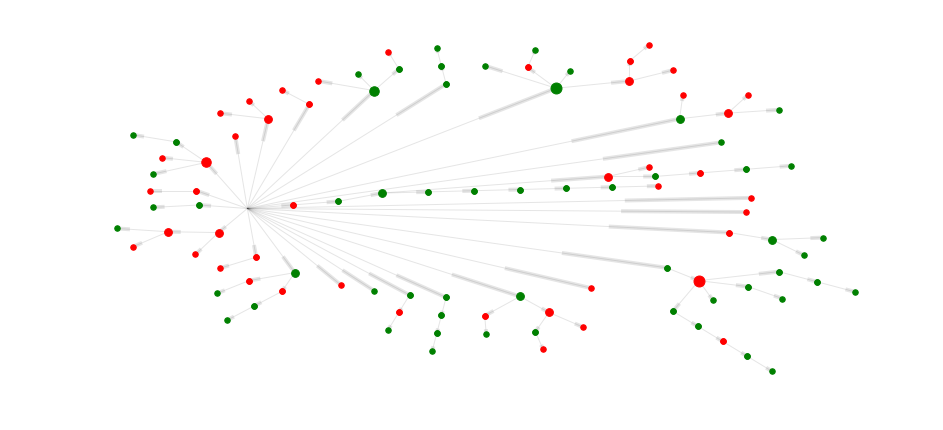

In [44]:
# Select Url / Subreddit page to view
page = 'portland'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts
col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

df = pd.DataFrame(columns = col_list)

G_dict = {}

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads

        comments = submission.comments.list() #unstructured
        G = nx.DiGraph()
        positive_nodes = []
        negative_nodes = []
        # Build empty dict
        degrees = {}
        for i in range(1,30):
            degrees[i] = []
            
        for i, comment in enumerate(comments):
            df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
            try:
                sentiment = str(prediction(comment.body))
                if sentiment == "Negative":
                    negative_nodes.append(comment.id)
#                     degree.append(nx.degree(G))
                if sentiment == "Positive":
                    positive_nodes.append(comment.id)
                G.add_node(comment.id)
                G.add_edge(comment.parent(), comment.id)
            except:
                continue
            
        degree = nx.degree(G)
        for id,count in degree.items():
            for i in range(1,30):
                if count == i:
                    degrees[i].append(id)
        G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)
        
df.to_csv(page+'.csv', encoding='utf-8', index=False)

i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.pydot_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()
    
    

Title: Road rage: interrupted., ups: 16960, downs: 0, Have we visited: False


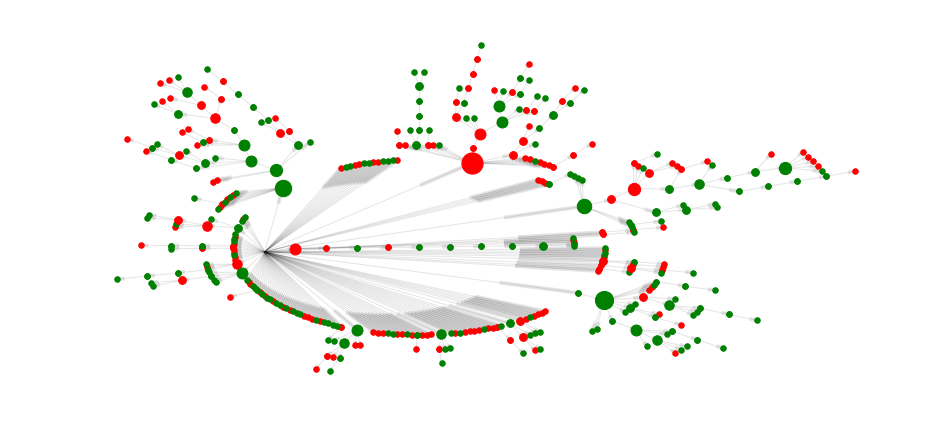

Title: When you're 7 Feet Tall, Life is an Obstacle., ups: 36861, downs: 0, Have we visited: False


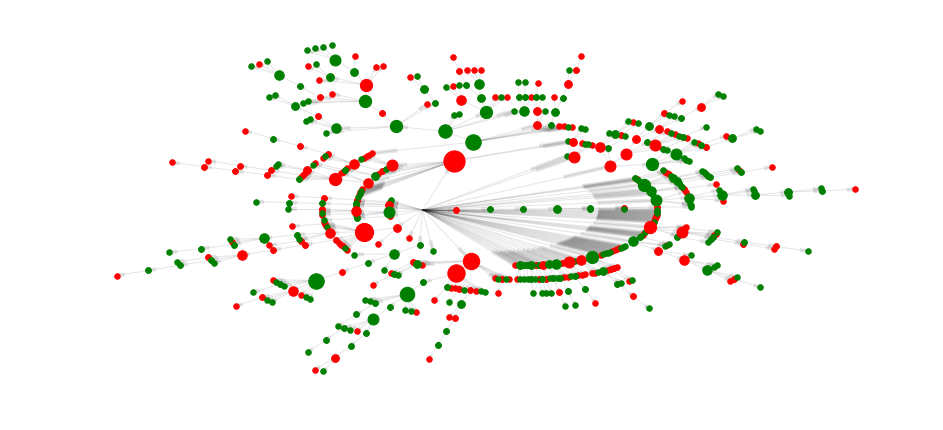

In [51]:
# Select Url / Subreddit page to view
page = 'funny'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts
col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

df = pd.DataFrame(columns = col_list)

G_dict = {}

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads

        comments = submission.comments.list() #unstructured
        G = nx.DiGraph()
        positive_nodes = []
        negative_nodes = []
        # Build empty dict
        degrees = {}
        for i in range(1,30):
            degrees[i] = []
            
        for i, comment in enumerate(comments):
            df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
            try:
                sentiment = str(prediction(comment.body))
                if sentiment == "Negative":
                    negative_nodes.append(comment.id)
#                     degree.append(nx.degree(G))
                if sentiment == "Positive":
                    positive_nodes.append(comment.id)
                G.add_node(comment.id)
                G.add_edge(comment.parent(), comment.id)
            except:
                continue
            
        degree = nx.degree(G)
        for id,count in degree.items():
            for i in range(1,30):
                if count == i:
                    degrees[i].append(id)
        G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)
        
df.to_csv(page+'.csv', encoding='utf-8', index=False)

i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.pydot_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()
    
    

Title: Lucasfilm to start production on Obi-Wan Kenobi Star Wars spinoff in January 2019, ups: 20195, downs: 0, Have we visited: False


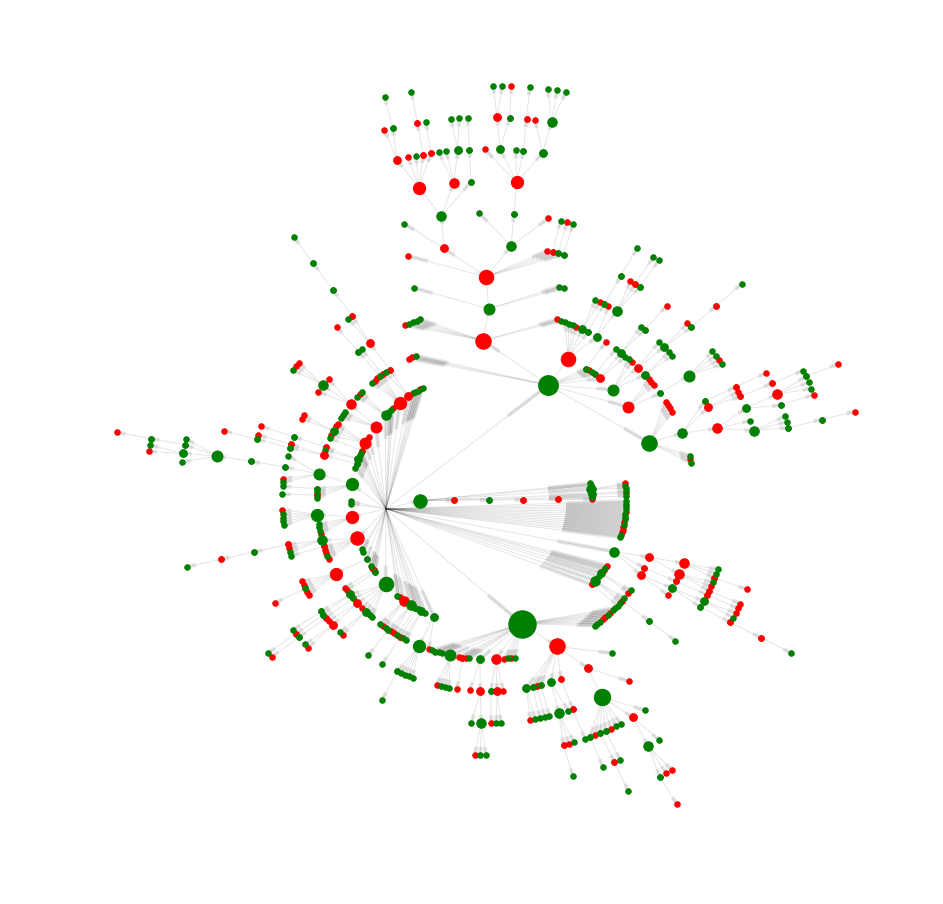

In [46]:
# Select Url / Subreddit page to view
page = 'movies'

subreddit = reddit.subreddit(page)
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts
col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

df = pd.DataFrame(columns = col_list)

G_dict = {}

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads

        comments = submission.comments.list() #unstructured
        G = nx.DiGraph()
        positive_nodes = []
        negative_nodes = []
        # Build empty dict
        degrees = {}
        for i in range(1,30):
            degrees[i] = []
            
        for i, comment in enumerate(comments):
            df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
            try:
                sentiment = str(prediction(comment.body))
                if sentiment == "Negative":
                    negative_nodes.append(comment.id)
#                     degree.append(nx.degree(G))
                if sentiment == "Positive":
                    positive_nodes.append(comment.id)
                G.add_node(comment.id)
                G.add_edge(comment.parent(), comment.id)
            except:
                continue
            
        degree = nx.degree(G)
        for id,count in degree.items():
            for i in range(1,30):
                if count == i:
                    degrees[i].append(id)
        G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)
        
df.to_csv(page+'.csv', encoding='utf-8', index=False)

i = 0
for sub,G in G_dict.items():
    print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                  sub.ups,
                                                                  sub.downs,
                                                                  sub.visited))
    i += 1

    pos = nx.nx_pydot.pydot_layout(G[0], prog='twopi', args='')

    plt.figure(figsize=(16, 16))
    plt.subplot(len(G_dict), 1, i)

    for j in range(1,30):
        pos_j = []
        neg_j = []
        for k in G[3][j]:
            if k in G[1]:
                pos_j.append(k)
            if k in G[2]:
                neg_j.append(k)
        nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
        nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
    nx.draw_networkx_edges(G[0], pos, alpha=0.1)
    plt.axis('off')
    plt.show()
    
    

In [ ]:
# Select Url / Subreddit page to view
page = 'movies'

In [52]:
def predict_subreddit(page='news'):

    subreddit = reddit.subreddit(page)
    hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts
    col_list = ['parent_id', 'comment_id', 'body', 'predict_sentiment']

    df = pd.DataFrame(columns = col_list)

    G_dict = {}

    for submission in hot_python:
        if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
            submission.comments.replace_more(limit=0) #this needs to be strung in here to view longer threads

            comments = submission.comments.list() #unstructured
            G = nx.DiGraph()
            positive_nodes = []
            negative_nodes = []
            # Build empty dict
            degrees = {}
            for i in range(1,30):
                degrees[i] = []

            for i, comment in enumerate(comments):
                df.loc[i] = [comment.parent(), comment.id, comment.body, prediction(comment.body)]
                try:
                    sentiment = str(prediction(comment.body))
                    if sentiment == "Negative":
                        negative_nodes.append(comment.id)
    #                     degree.append(nx.degree(G))
                    if sentiment == "Positive":
                        positive_nodes.append(comment.id)
                    G.add_node(comment.id)
                    G.add_edge(comment.parent(), comment.id)
                except:
                    continue

            degree = nx.degree(G)
            for id,count in degree.items():
                for i in range(1,30):
                    if count == i:
                        degrees[i].append(id)
            G_dict[submission] = (G, positive_nodes, negative_nodes, degrees)

    df.to_csv(page+'.csv', encoding='utf-8', index=False)

    i = 0
    for sub,G in G_dict.items():
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(sub.title,
                                                                      sub.ups,
                                                                      sub.downs,
                                                                      sub.visited))
        i += 1

        pos = nx.nx_pydot.pydot_layout(G[0], prog='twopi', args='')

        plt.figure(figsize=(16, 16))
        plt.subplot(len(G_dict), 1, i)

        for j in range(1,30):
            pos_j = []
            neg_j = []
            for k in G[3][j]:
                if k in G[1]:
                    pos_j.append(k)
                if k in G[2]:
                    neg_j.append(k)
            nx.draw_networkx_nodes(G[0], pos, nodelist=neg_j, node_size=j*30, node_color='r')
            nx.draw_networkx_nodes(G[0], pos, nodelist=pos_j, node_size=j*30, node_color='g')
        nx.draw_networkx_edges(G[0], pos, alpha=0.1)
        plt.axis('off')
        plt.show()

Title: My 4 year old found permanent markers and is so proud that he is now Darth Maul., ups: 2731, downs: 0, Have we visited: False


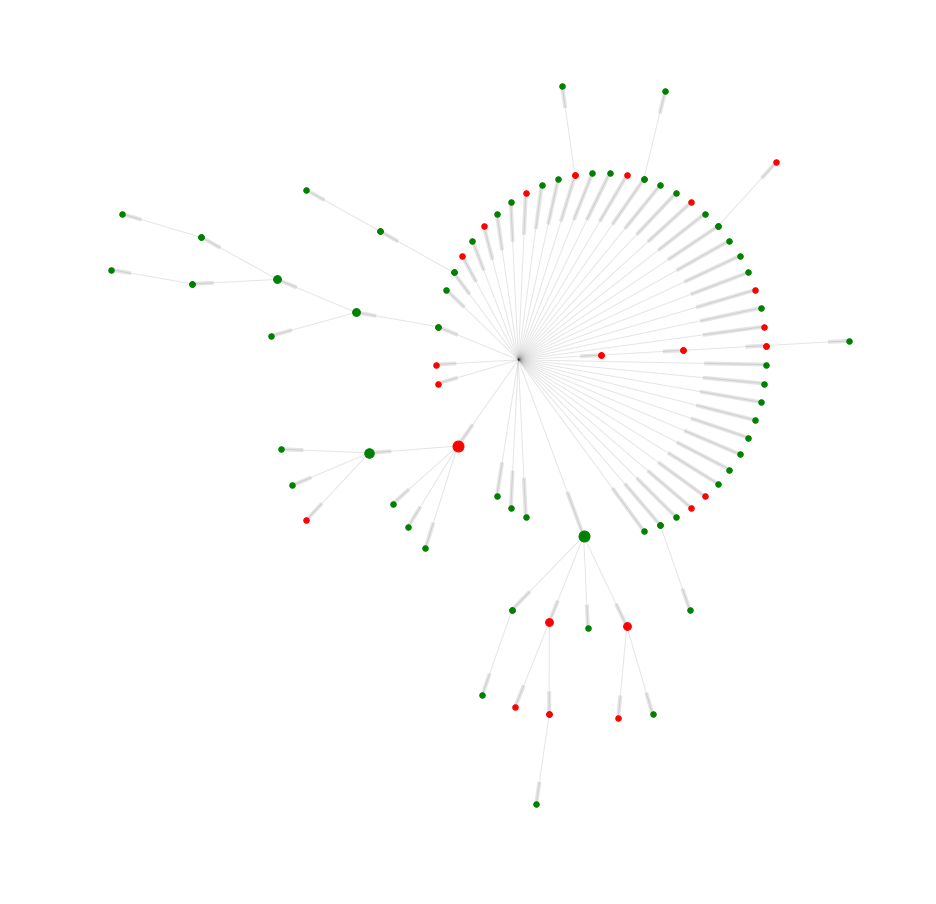

In [53]:
predict_subreddit('starwars')

Title: This is Katie Hill from Santa Clarita. Katie was the CEO of a non-profit that serves the homeless. Now she's running for congress against a certain boat-faced congressman from Palmdale who voted to repeal the wildfire loss deduction while our state was on fire. 🚒🔥, ups: 8753, downs: 0, Have we visited: False


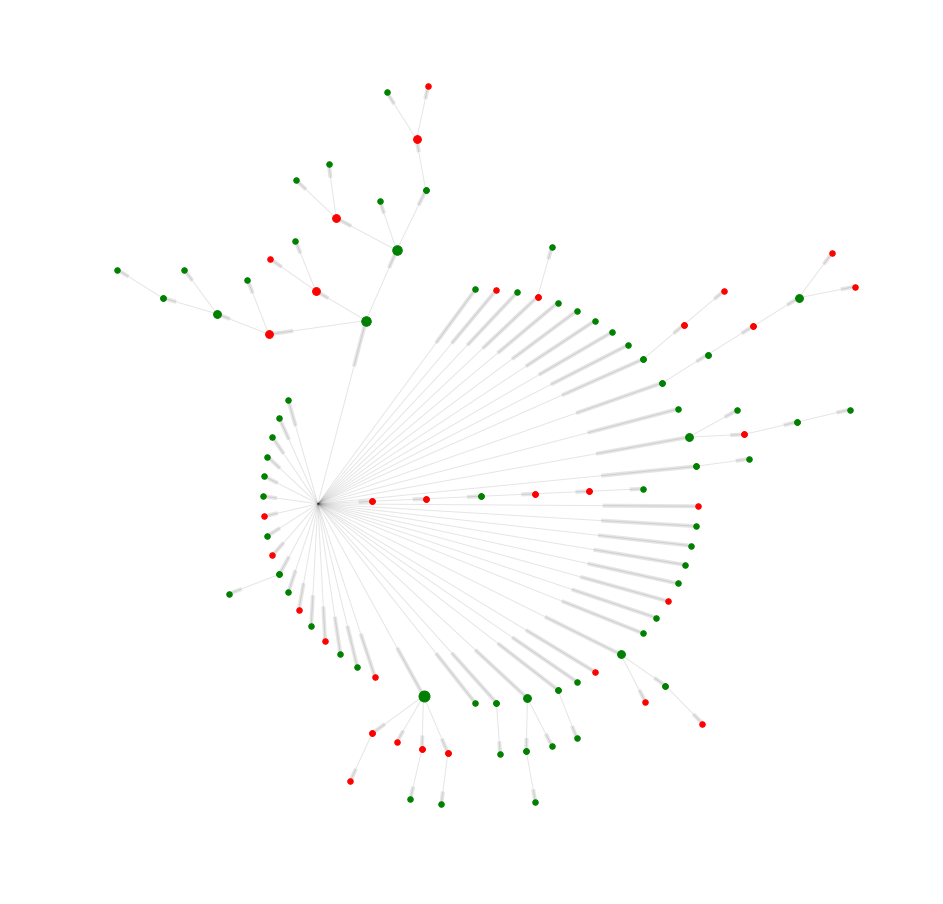

In [54]:
predict_subreddit('losangeles')

Title: Any interests besides spidering?, ups: 11, downs: 0, Have we visited: False


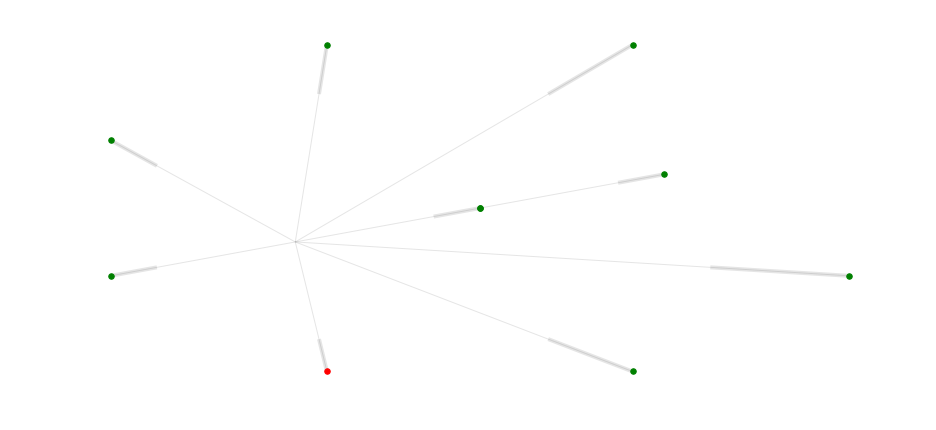

Title: Any idea what kind of spider this is? Santa Fe County, New Mexico, ups: 73, downs: 0, Have we visited: False


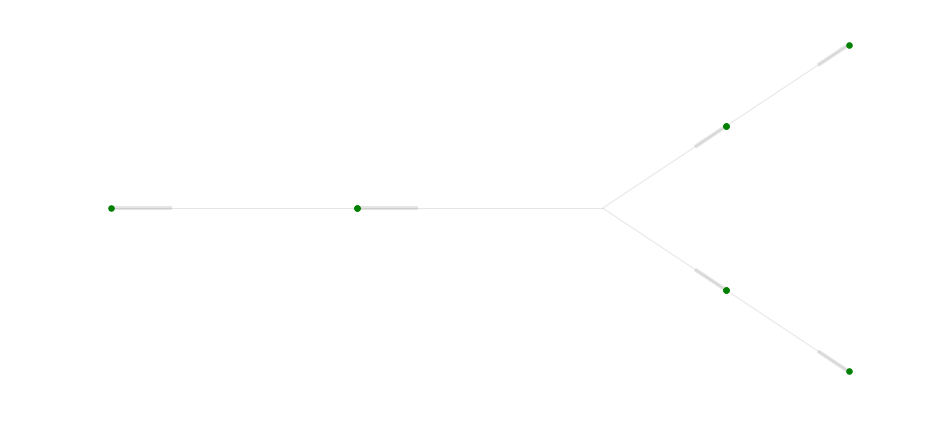

In [55]:
predict_subreddit('spiders')

Title: [Video]Bob Ross Parody painting of Mosasaur attacking Pteranodon, ups: 26, downs: 0, Have we visited: False


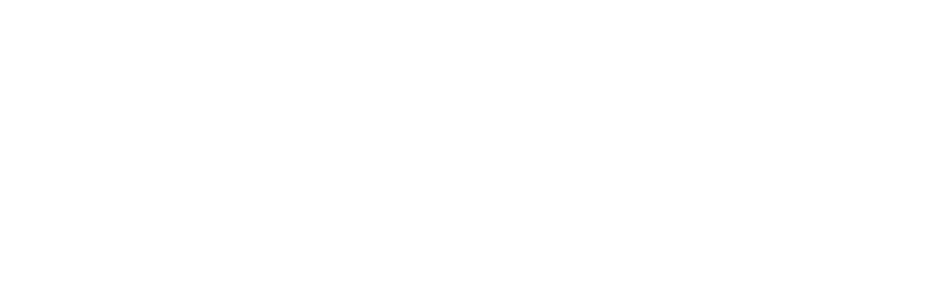

Title: [Video] "Battle of the Salt Plains" from the Ballad of Big Al. One of the most epic soundtracks I have ever heard in a prehistory documentary., ups: 88, downs: 0, Have we visited: False


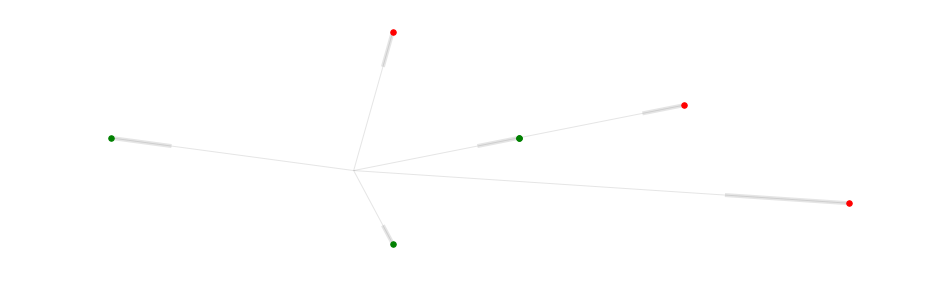

Title: [Article] Halszkaraptor escuilliei: Bizarre New Dinosaur Was a Mix of Aquatic Bird and Theropod, ups: 10, downs: 0, Have we visited: False


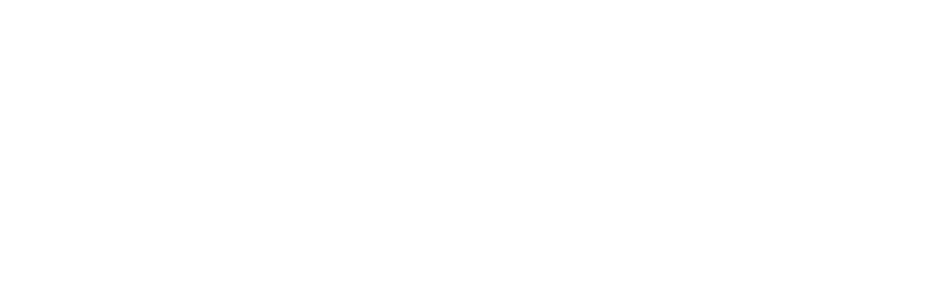

Title: I rode a bicycle across the US, Canada, Mexico and Japan alone. AMA, ups: 20, downs: 0, Have we visited: False


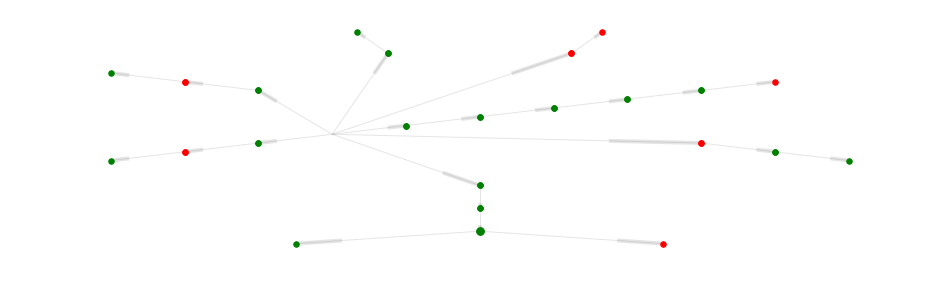

Title: I am a Swedish male residing in one of the "no-go zones". My ethnical background (if it is interesting) is 50% Saami and 50% Swedish (ancient Valonians aswell). I'm thinking questions about PC, migration and freedom of speech are the most interesting topics, but ask me anything!, ups: 22, downs: 0, Have we visited: False


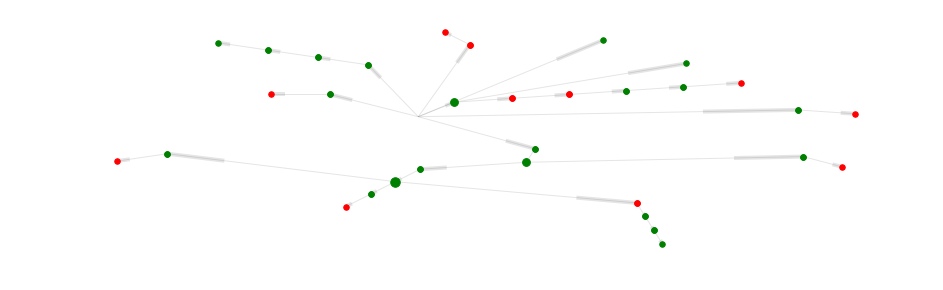

Title: I live in a city in sweden that builds a giant goat statue out of hay every december and every year it gets burned down by a civilian, ups: 30, downs: 0, Have we visited: False


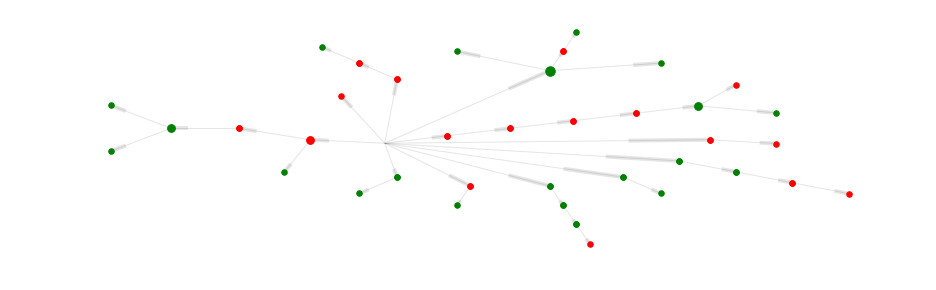

In [56]:
predict_subreddit('dinosaurs')
predict_subreddit('ama')